### The Full Outflow Mass Pipeline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


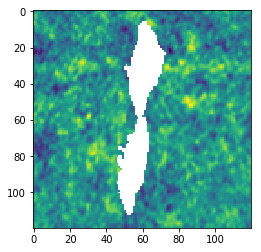

In [15]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, "..")
from stamp import *
from physics import *
%load_ext autoreload
%autoreload 2

#Read in data.
c12 = SpectralCube.read("../../cubes/mask_imfit_12co_pix_2_Tmb.fits")
c13 = SpectralCube.read("../../cubes/mask_imfit_13co_pix_2_Tmb_regrid12co.fits")
c18 = SpectralCube.read("../../cubes/mask_imfit_c18o_pix_2_Tmb.fits")

t_hops = Table.read("../../catalogs/hops.fits")

#Define coordinate and visually determined outflow velocities.
#(These can be read from the outflow_hunt.csv) For the pipeline, I'll loop over each entry in this table
#which has a confirmed outflow.
hops_id = 169
hops = t_hops[t_hops["HOPS"] == hops_id][0]
coord = SkyCoord(hops["RAJ2000"], hops["DEJ2000"], unit=u.deg)
vblue, vred = 4.7*u.km/u.s, 10*u.km/u.s

#Extract subcube around the outflow to make it easier to work with. The subcube need not be exactly
#snug around the outflow, but should include the entire outflow region.
#All calculations will be done on the outflow region.
width=height=4*u.arcmin

sub12 = extract_subcube(c12, region_class=RectangleSkyRegion,
                      region_kwargs=dict(center=coord, width=width, height=height))
sub13 = extract_subcube(c13, region_class=RectangleSkyRegion,
                        region_kwargs=dict(center=coord, width=width, height=height))

#Define mask to select only pixels to include in outflow calculations. I should probably draw a region
#manually around each outflow for these purposes, then I can further select pixels toward a contour in the
#moment0 maps at high velocities.
from regions import read_ds9
mask_outflow = np.load("mask_outflow.npy")
sub12_outflow = sub12.with_mask(mask_outflow)
print(~mask_outflow)
# reg_outflow = read_ds9("outflow_hops169.reg")
# sub12_reg = sub12.subcube_from_regions(reg_outflow)
# sub12_mask = sub12.with_mask(mask_outflow)
# print(mask_outflow_ds9)
# fig, ax = plt.subplots(1,2)
# ax[0].imshow(sub12_reg.moment0().data)
# ax[1].imshow(sub12_mask.moment0().data)
# mask_outflow_ds9.shape
# plt.imshow(sub12.with_mask(mask_outflow_ds9)[0].data)
plt.imshow(sub12.with_mask(~mask_outflow).filled_data[:,:,:][0].data)

In [25]:
#Calculate RMS in emission-free channels. Only consider pixels outside outflow mask.
rms12 = rms(sub12.with_mask(~mask_outflow), velocity_range=[[-2,0],[18,20]]*u.km/u.s)
rms13 = rms(sub13.with_mask(~mask_outflow), velocity_range=[[0,2], [16,18]]*u.km/u.s)

mask_bluelobe = sub12.spectral_slab(-2*u.km/u.s, 4.7*u.km/u.s).moment0() > 10*sigma_mom0(
    sub12.spectral_slab(-2*u.km/u.s, 4.7*u.km/u.s), channel_sigma=rms12)
np.save("mask_bluelobe", mask_bluelobe)

#Compute SNR mask at 3 sigma.
mask12_3sig = sub12 > 3*rms12
mask13_3sig = sub13 > 3*rms13
mask12_5sig = sub12 > 5*rms12
mask13_5sig = sub13 > 5*rms13
print(rms12, rms13)

0.8506656289100647 K 0.3815724551677704 K


43.95673885824482 K


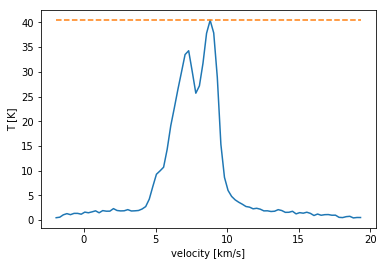

In [4]:
#Calculate Tex using the peak temperature of the average 12co spectrum.
Tex_peak = cube_Tex(sub12_outflow, thick=True, plot="tex.png", average=True, average_first=True)
print(Tex_peak)

In [5]:
#Fit the C18O spectrum with 1 or more gaussians to get the mean velocity of the cloud, or cloud components
#along the line of sight.
c18o_radius = 15*u.arcsec
sub18 = extract_subcube(c18, region_class=CircleSkyRegion,
                                    region_kwargs=dict(center=coord, radius=15*u.arcsec))

spec18_mean = extract_spectrum(sub18, spectral_unit=u.km/u.s)

spec18_gauss = fit_gaussian(spec18_mean.spectral_axis, spec18_mean, n_models=2, autoguess=True)
vsys = np.sort([g.mean.value for g in spec18_gauss])*spec18_mean.spectral_axis.unit
print("Fitted C18O cloud components at", vsys)

{'amplitude': <Quantity [2.4625492, 3.7193773] K>, 'mean': <Quantity [8.95106424, 6.9708122 ] km / s>, 'stddev': <Quantity [0.21271516, 0.30323633] km / s>}
Model: CompoundModel0
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=2.46254921, mean=8.95106424, stddev=0.21271516)>

    [1]: <Gaussian1D(amplitude=3.71937728, mean=6.9708122, stddev=0.30323633)>
Parameters:
       amplitude_0           mean_0      ...       mean_1           stddev_1     
    ------------------ ----------------- ... ----------------- ------------------
    2.1932958203336925 8.852389648536008 ... 7.002838216725236 0.2778192220831075
Fitted C18O cloud components at [7.00283822 8.85238965] km / s


[7002.83821673 8852.38964854]


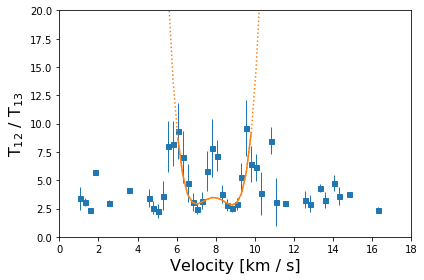

In [6]:
#Compute the velocity-dependent opacity correction. This could be fitting either a quadratic, or a 4-th order polynomial
#if there are two distinct cloud components.
fit_range = [6,10]*u.km/u.s
sub12_correct, correctfactor = opacity_correct(sub12.with_mask(mask_outflow).with_mask(mask12_3sig), 
                                          sub13.with_mask(mask_outflow).with_mask(mask13_3sig), weighted_fit=True, fixed_fit=True,
                                          snr_cutoff=0, fit_func="poly4", vsys=vsys, fit_range=fit_range,    
                                          plot_ratio=True,
                                          errorbar_kwargs=dict(markersize=5, marker='s', ls='', lw=1, zorder=0),           
                                          plot_kwargs=dict(c='tab:orange'),
                                          return_factor=True)

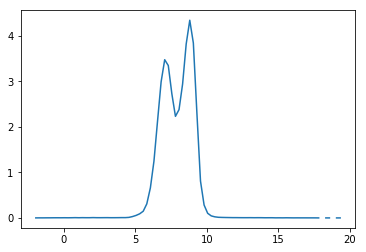

In [7]:
#Compute the mass spectrum in the outflow region
#and integrate starting 1 km/s away from the peak(s) to get the total mass of the outflow.
#the mass spectrum and masscube both have units of Msun / (km/s)
dmdv_correct, masscube_correct = dmdv(sub12_correct.with_mask(mask12_5sig), molecule='12co', Tex=Tex_peak,
                                     return_cube=True)
plt.plot(dmdv_correct.spectral_axis, dmdv_correct)

{'amplitude': <Quantity [3.4722303 , 4.33829142] s solMass / km>, 'mean': <Quantity [7.06355976, 8.81406386] km / s>, 'stddev': <Quantity [0.31348053, 1.17115299] km / s>}
Model: CompoundModel1
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=3.4722303, mean=7.06355976, stddev=0.31348053)>

    [1]: <Gaussian1D(amplitude=4.33829142, mean=8.81406386, stddev=1.17115299)>
Parameters:
       amplitude_0           mean_0      ...       mean_1            stddev_1     
    ------------------ ----------------- ... ----------------- -------------------
    3.4491195389401588 7.155462682753484 ... 8.805283171785517 0.44537903213396485


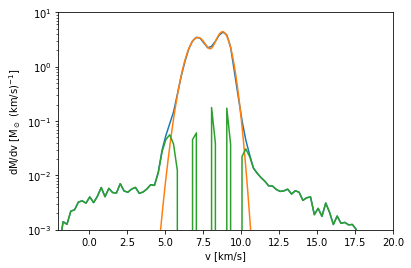

In [8]:
#Fit the mass spectrum with two gaussians and subtract off the cloud spectrum.
dmdv_outflow = ambient_correct(dmdv_correct, n_models=2, plot=True,
                               autoguess=True)
# print(dmdv_outflow)

In [9]:
#Integrate the outflow mass spectrum from +/- 1 km/s away from peak velocities.`
# dmdv_outflow.spectral_axis
mass_total = sum_dmdv(dmdv_outflow, vsys=vsys, vrange='auto', dv=1*u.km/u.s)
print(mass_total)

0.12518296830612397 solMass


In [29]:
#Calculate the momentum and kinetic energy in the outflow. The only question here is what velocity
#do we use for each channel? It should be the outflow velocity, but what do we do in the case there is 
#more than one cloud velocity component?
v_out_blue = abs(min(vsys) - dmdv_outflow.spectral_axis)
v_out_red = abs(max(vsys) - dmdv_outflow.spectral_axis)
i_blue = dmdv_outflow.spectral_axis <= min(vsys)
i_red = dmdv_outflow.spectral_axis >= max(vsys)
i_between = (dmdv_outflow.spectral_axis >= min(vsys)) & (dmdv_outflow.spectral_axis <= max(vsys))
v_out = np.copy(v_out_blue)
v_out[dmdv_outflow.spectral_axis >= max(vsys)] = v_out_red[dmdv_outflow.spectral_axis >= max(vsys)]
v_out[i_between] = 0
# print(v_out)
# print(v_out_blue)
print(sum_dmdv(dmdv_outflow, vsys=vsys, vrange='auto', dv=1*u.km/u.s, return_lobes=True))
print(momentum_dmdv(dmdv_outflow, vsys=vsys, vrange='auto',dv=1*u.km/u.s, return_lobes=True))
print(energy_dmdv(dmdv_outflow, vsys=vsys, vrange='auto', dv=1*u.km/u.s, return_lobes=True))

(<Quantity 0.07560495 solMass>, <Quantity 0.04957802 solMass>)
(<Quantity 0.22904675 km solMass / s>, <Quantity 0.15268601 km solMass / s>)
(<Quantity 0.48770846 km2 solMass / s2>, <Quantity 0.32596052 km2 solMass / s2>)


Guessing position angle of 2.2578807301177677 deg
Guessing these parameters:  {'amplitude': 80.0, 'mean': 6.359368034839363, 'stddev': 138.47378130867486}
[[ 1.76064020e+00  3.65263092e-17 -1.70620153e-01]
 [ 3.65263092e-17  4.96033829e-02 -1.30960339e-17]
 [-1.70620153e-01 -1.30960339e-17  4.96033829e-02]]


(<Quantity 10.74952775 deg>, <Quantity 33.49015179 deg>)

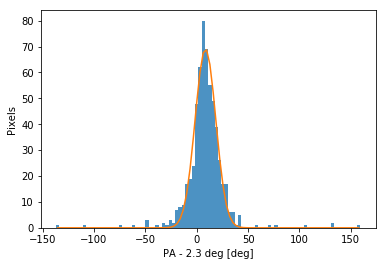

In [54]:
from physics import outflow_angles
outflow_angles(sub12.with_mask(mask_bluelobe), autoguess=True,
               plot=True, plothist_kwargs=dict(facecolor='tab:blue', alpha=0.8))